Let's replicate one of the experiments in the PatternBoost paper REF. In particular, we will describe a machinery for generating maximal triangle-free graphs. 

In a nutshell, PatternBoost is a framework for generating less trivial examples from more trivial in arbitrary mathematical domains.  The only prerequisities for setting it up are:

0. Kinda unspoken prerequsite is that you are able to encode you mathematical structures of interest into computer.

1. The quanitifable notion of the "non-triviality", here it will take a form of a reward function $r: X \to \mathbb R_+$, with $X$ being the set of objects of interest, which includes our original set of examples. The bigger the value of $r(x)$, the more non-trivial $x$ is.

2. The "obvious" way how, given $x$ construct $x'$ such that $r(x) \leq r(x')$. Usually it takes form of a greedy (not necessary deterministic) algorithm $A : X \to X$ that tries to modify $x$ to increase its reward

In practice the algorithm $G$ alone is not enough to come up with very non-trivial examples (examples with high reward), since in compilcated situations it performs a "local" optimization, rather than a "global" one. To compliment the local search, authors of REF suggest to use an additional generation step, which in our case will be performed by a decoder LLM. Let's sketch their approach. Fix the number of iterations $n$ and proceed as follows:

__Step 0.__ Obtain an initial dataset of examples $X_0$ (of size $k$), by appling $A$ to some set of "trivial" examples.

Step 1. Compute $r(x)$ for all $x \in X_0$ and take the top 25% of examples in $X_0$ in terms of $r$ to obtain our first training dataset $X_0^{\mathrm{top}}$

Step 2. Train an autoregressive model $M$ on $X_0^{\mathrm{top}}$, the model will hopefully learn some of the statistical patterns of the top examples.

Step 3. Generate $k$ new examples from $M$ to obtain the new set of examples $X_1$

Step 4. Repeat the process from Step 0, substituting $X_0$ with $X_1$ and so on.

Step 5. Inspect $X_n$ for interesting examples with high rewards.

To summarize, PatternBoost can be thought of as a certain global optimization algorithm for functions $r$ defined on sequential data.

The application that we will explore in this notebook is a search of maximal triangle-free graphs. Fix a number $N$ and consider all (simple) graphs on $N$ vertices that do not have triangles, i.e. cycles of length $3$. How many edges such graphs can have? How these graphs with maximal possible number of edges look like? This problem have all three prerequisistives to apply PatternBoost:

0. Computer representation: After ordering the vertices every graph can be encoded by its adjacency matrix. To make this representation sequential we unroll the upper-diagonal part of the matrix row by row and obtain a string of length $N(N-2)/2$ of $0$s and $1$s. 


1. Reward function: for a graph $g$ define $r(g)$ as $e(g) - 2t(g)$, where $e(g)$ is a number of edges in $g$ and $t(g)$ is a number of triangles in $g$. 



2. Local optimisation: given an arbitrary graph $g$ we can obtain a new triangle-free graph $A(g)$ by first removing one edge from each triangle in $g$ and then randomly adding edges without creating triangles (if possible) 

__Exercise:__ $r(g) \leq r(A(g))$

__Remark__

This toy problem have a known solution. It is not difficult to convince ourselves that bipartite graphs do not have triangles and indeed the maximal number of edges will be achived on a complete bipartite graph which have $\lceil N/2 \rceil^2$ edges. At the same time the complete answer for a similar question about maximal square-free graphs is unknown. Authors explore this question in Section REF of the paper. 

Let's start by defining the our graph representation, reward function and a local search algorithm $A$. Our implementation is adpated from the Julia code from author's repository REF.

In [3]:
# For now just import the basic things
import numpy as np
import random

In [4]:
#We will be working on the level of adjacency matrices and convert them to strings whenever necessary

def adjmat_to_string(adjmat):
    """
    Converts the upper-triangular entries of the adjacency matrix to a string.
    (Edges are read row by row, skipping the diagonal and lower-triangular part.)
    """
    n = adjmat.shape[0]
    entries = []
    for i in range(n - 1):
        for j in range(i + 1, n):
            entries.append(str(adjmat[i, j]))
    return "".join(entries)

def string_to_adjmat(obj, N):
    # Create an empty adjacency matrix
    adjmat = np.zeros((N, N), dtype=int)
    
    # Fill the upper triangular matrix from the input string `obj`
    index = 0
    for i in range(N - 1):
        for j in range(i + 1, N):
            # Convert the current character to an integer (0 or 1)
            value = int(obj[index])
            adjmat[i, j] = value
            adjmat[j, i] = value  # Ensure the matrix is symmetric
            index += 1
    return adjmat

In [5]:
def find_all_triangles(adjmat):
    """
    Auxiliary function for finding all triangles in the undirected graph represented by adjmat.
    Each triangle is returned as a tuple (i, j, k) with i < j < k.
    """
    n = adjmat.shape[0]
    triangles = []
    for i in range(n - 2):
        for j in range(i + 1, n - 1):
            for k in range(j + 1, n):
                if adjmat[i, j] == 1 and adjmat[j, k] == 1 and adjmat[i, k] == 1:
                    triangles.append((i, j, k))
    return triangles

# Here is our reward function

def r(obj, N):
    """
    Calculates the reward of a construction.

    Input:
      - obj: A string representing the upper-triangle of an adjacency matrix.
             The length should be N*(N-1)//2.
      - N: The number of nodes in the graph.
    Returns:
      Number of edges minus twice the number of triangles.
    """
    edges = obj.count('1')
    triangles = len(find_all_triangles(string_to_adjmat(obj, N)))
    return edges - 2 * triangles

__Remark__ 

The implementation of the reward function in authors repository differs from one they use in the paper. In repository they use just $r(g) = e(g)$. Here we follow the definition from the paper

In [6]:
# Finally we define our local search algorithm A

def A(obj, N):
    """
    Main greedy search algorithm.
    Input:
      - obj: A string representing the upper-triangle of an adjacency matrix.
             The length should be N*(N-1)//2.
      - N: The number of nodes in the graph.
    
    The algorithm:
      1. Builds a symmetric N x N adjacency matrix from obj.
      2. Greedily removes edges that participate in triangles until no triangle exists.
      3. Greedily adds random edges that do not create any triangle until no such edge remains.
    Returns:
      A string representation of the final upper-triangular adjacency matrix.
    """
    # Create an empty adjacency matrix
    adjmat = np.zeros((N, N), dtype=int)
    
    # Fill the upper triangular matrix from the input string `obj`
    index = 0
    for i in range(N - 1):
        for j in range(i + 1, N):
            # Convert the current character to an integer (0 or 1)
            value = int(obj[index])
            adjmat[i, j] = value
            adjmat[j, i] = value  # Ensure the matrix is symmetric
            index += 1

    # Remove triangles by deleting the most frequent edge in any triangle until no triangles remain.
    triangles = find_all_triangles(adjmat)
    while triangles:
        edge_count = {}
        for (i, j, k) in triangles:
            for edge in [(i, j), (j, k), (i, k)]:
                edge_count[edge] = edge_count.get(edge, 0) + 1

        # Find the edge that appears in the most triangles
        most_frequent_edge = max(edge_count, key=edge_count.get)
        i_edge, j_edge = most_frequent_edge

        # Remove this edge from the graph
        adjmat[i_edge, j_edge] = 0
        adjmat[j_edge, i_edge] = 0

        # Update triangles by removing those that contain the removed edge
        triangles = [
            t for t in triangles 
            if most_frequent_edge not in [(t[0], t[1]), (t[1], t[2]), (t[0], t[2])]
        ]

    # Now add allowed edges (those that do not create a triangle) one by one at random.
    allowed_edges = []
    # Compute the square of the adjacency matrix to count two-step connections
    adjmat2 = np.dot(adjmat, adjmat)
    for i in range(N - 1):
        for j in range(i + 1, N):
            if adjmat[i, j] == 0 and adjmat2[i, j] == 0:
                allowed_edges.append((i, j))

    while allowed_edges:
        # Randomly select an edge to add
        edge = random.choice(allowed_edges)
        i_edge, j_edge = edge
        adjmat[i_edge, j_edge] = 1
        adjmat[j_edge, i_edge] = 1

        # Update allowed_edges by removing those that would form a triangle with the newly added edge
        new_allowed_edges = []
        for (a, b) in allowed_edges:
            # Skip the newly added edge if it's still in the list
            if (a, b) == (i_edge, j_edge):
                continue

            # Check if adding (a,b) now would create a triangle with the new edge (i_edge, j_edge)
            if (a == i_edge and adjmat[b, j_edge] == 1) or \
               (a == j_edge and adjmat[b, i_edge] == 1) or \
               (b == i_edge and adjmat[a, j_edge] == 1) or \
               (b == j_edge and adjmat[a, i_edge] == 1):
                continue

            new_allowed_edges.append((a, b))
        allowed_edges = new_allowed_edges

    return adjmat_to_string(adjmat)

In [7]:
# IT also will be usefull to have a starting point: a graph on N vertices with no edges

def empty_starting_point(N):
    """
    Returns an empty starting point as a string.
    The string consists of "0" repeated for every possible upper-triangle entry.
    """
    return "0" * (N * (N - 1) // 2)

Now lets follow the steps to recreate $X_i$ described above. We will construct $X_0$ and $X_1$ separately and do the rest in a loop.

Organizational remarks: we will try to utilize HF's $\texttt{transformers}$ library abstractions as much as possible to reduce the training boilerplate code.

In [ ]:
# for setting the environment variables and paths
import os

# for parallel computation of A and r
from multiprocessing import Pool

# for working with tensors and sending them around
import torch

# HF stuff for tokenization
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

# HF stuff for storing the datasets X_i
from datasets import Dataset


# HF stuff for training and generating
from transformers import (
    GPT2Config, 
    GPT2LMHeadModel,
    Trainer, 
    TrainingArguments,
    DataCollatorForLanguageModeling,
    PreTrainedTokenizerFast,
    pipeline
)

# Pretty progress bars and histogram plotting
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [11]:
# Let's set up our enviroment variables, paths, devices and seeds

os.environ['TOKENIZERS_PARALLELISM'] = 'false' # to avoid warnings while using multiprocessing

os.environ["CUDA_VISIBLE_DEVICES"] = "3" # choose your GPU index if you have a multi-gpu setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # normally Trainer choose the device by itself, but for generation we will need it to move the batches around.

data_path = "PB_data/" # path to store the data
os.makedirs(data_path, exist_ok=True)

SEED = 42 # for reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [12]:
# For the rest of the notebook we fix our number of vertices N at 20
N = 20

# Step 0: generate the initial dataset $X_0$

In [14]:
# Starting with a trivial graph, we will randomly add edges to it until no more edges can be added without creating a triangle.

def _generate_sample(_):
    empty = empty_starting_point(N)
    graph = A(empty, N)
    reward = r(graph, N)
    return {"text": graph, "reward": reward}

def generate_initial_dataset(num_samples):
    """
    Generate initial dataset by running greedy search from empty graphs.
    
    Args:
        num_samples: Number of samples to generate
    
    Returns:
        HuggingFace Dataset containing the generated graphs
    """
    dataset_path = os.path.join(data_path, f"X_0")
    if os.path.exists(dataset_path):
        print(f"Loading dataset from {dataset_path}...")
        dataset = Dataset.load_from_disk(dataset_path)
    else:
        print(f"Generating initial dataset with {num_samples} samples...")
        
        # Generate samples using multiprocessing
        with Pool() as pool:
            samples = list(tqdm(pool.imap_unordered(_generate_sample, range(num_samples)), total=num_samples))
        
        dataset = Dataset.from_list(samples)
        dataset.save_to_disk(dataset_path)
    return dataset

# Following the paper we will start with 40k samples

X_0 = generate_initial_dataset(num_samples=40_000)

Generating initial dataset with 40000 samples...


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/40000 [00:00<?, ? examples/s]

# Step 1: take examples with top rewards

In [16]:
# Now let's sort the dataset by rewards and take the top 25% of the samples to obtain X_0^{top}

X_0 = X_0.sort("reward", reverse=True)
X_0_top = X_0.select(range(len(X_0) // 4))

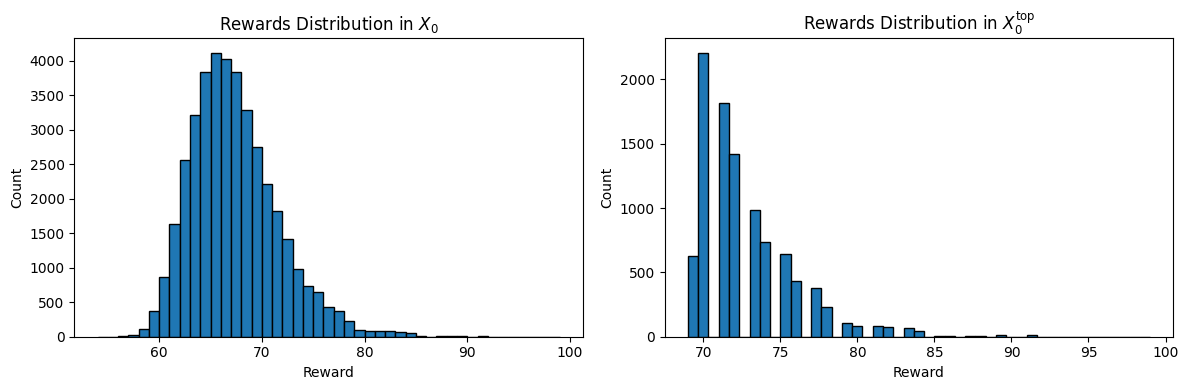

In [20]:
# Here are the rewards distributions for X_0 and X_0_top (compare with Figure 1 in the paper)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot histogram for X_0
ax1.hist(X_0['reward'], bins=45, edgecolor='black', linewidth=1)
ax1.set_title('Rewards Distribution in $X_0$')
ax1.set_xlabel('Reward')
ax1.set_ylabel('Count')

# Plot histogram for X_0_top
ax2.hist(X_0_top['reward'], bins=45, edgecolor='black', linewidth=1)
ax2.set_title('Rewards Distribution in $X_0^{\mathrm{top}}$')
ax2.set_xlabel('Reward')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [21]:
# Authors suggest to train a BPE tokenizer with a vocabulary of 100 tokens to reduce the lengths of the sequences.

def initialize_tokenizer():
    """
    Initialize and train a BPE tokenizer with vocabulary size of 100.

    Returns:
        A trained tokenizer object
    """
    tokenizer_path = os.path.join(data_path, f"tokenizer_N{N}")

    if os.path.exists(tokenizer_path):
        print(f"Loading tokenizer from {tokenizer_path}...")
        tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)
    else:
        print("Training new tokenizer...")
        raw_tokenizer = Tokenizer(BPE())
        raw_tokenizer.pre_tokenizer = Whitespace()
        
        # Following the repository: train on the first 5000 samples
        trainer = BpeTrainer(vocab_size=100)
        raw_tokenizer.train_from_iterator(X_0_top['text'][:5000], trainer=trainer)
        
        tokenizer = PreTrainedTokenizerFast(
            tokenizer_object=raw_tokenizer,
            bos_token="<s>",
            eos_token="</s>",
            pad_token="<pad>"
        )
        
        tokenizer.save_pretrained(tokenizer_path)

    return tokenizer

tokenizer = initialize_tokenizer()

Training new tokenizer...





__Remark__

Somehow the progress bar of the tokenizer training process is not rendering in Jupyter notebooks. Script version should not have this limitation. 

In [ ]:
# Before the training we need to tokenize the data.

def tokenize_function(examples):
    return tokenizer(examples["text"], 
                        padding=True, 
                        truncation=True,
                        max_length=50) # Our estimate for a new maximal length of the tokenized sequence

X_0_top_text = X_0_top.remove_columns(["reward"])

X_0_top_tokenized = X_0_top_text.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [25]:
# Let's check that our maximal length estimate (50) is reasonable.

max_len = 0
for seq in X_0_top_tokenized['input_ids']:
    try:
        length = seq.index(tokenizer.pad_token_id)
    except ValueError:
        length = len(seq)
    max_len = max(max_len, length)

print(f"New maximum sequence length: {max_len}")
print(f"Original maximum sequence length: {N * (N - 1) // 2}")


New maximum sequence length: 40
Original maximum sequence length: 190


# Step 2: training the model $M$

In [ ]:
# FIrst of all, split into train/eval sets

split_datasets = X_0_top_tokenized.train_test_split(test_size=0.1)

In [ ]:
# Here is our training config. All the hyperparameters are taken from the paper. In particular, we use a very small transformer and train it with a constant learning rate for 15000 steps


config = GPT2Config(
    vocab_size=len(tokenizer),
    n_positions=50, # same as maximal sequence length in the tokenizer
    n_embd=16,
    n_layer=2,
    n_head=4,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)


os.path.join(data_path, f"tokenizer_N{N}")
# Initialize model
model_path = os.path.join(data_path, f"model_0")
if os.path.exists(model_path):
    print(f"Loading model from {model_path}...")
    model = GPT2LMHeadModel.from_pretrained(model_path)
else:
    print("Initializing new model...")
    model = GPT2LMHeadModel(config)
model.to(device)


training_args = TrainingArguments(
    output_dir=os.path.join(data_path, f"generation_0"), # necessary argument, but not used in fact
    overwrite_output_dir=True,
    max_steps=15_000,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-4,
    lr_scheduler_type="constant",
    eval_strategy="steps",
    save_strategy="no",
    eval_steps=500, # set to higher value to reduce the output in the training cell
    logging_dir=os.path.join(data_path, f"logs/generation_0"),
    logging_steps=1000, # set to higher value to reduce the output in the training cell
    report_to="none" # optionally you can report to tensorboard, wandb etc to get nice visualizations of the training process
)


data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=False
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_datasets["train"],
    eval_dataset=split_datasets["test"],
    data_collator=data_collator,
)

max_steps is given, it will override any value given in num_train_epochs


Initializing new model...


In [29]:
# Run the training
trainer.train()

Step,Training Loss,Validation Loss
500,4.116300,4.087862
1000,4.031800,4.007880
1500,3.997700,3.974032
2000,3.979600,3.952378
2500,3.962500,3.939762
3000,3.956800,3.929595
3500,3.946300,3.920021
4000,3.940600,3.911060
4500,3.938100,3.904956
5000,3.927700,3.900764


TrainOutput(global_step=15000, training_loss=3.9344126749674477, metrics={'train_runtime': 203.027, 'train_samples_per_second': 2364.218, 'train_steps_per_second': 73.882, 'total_flos': 756148491264.0, 'train_loss': 3.9344126749674477, 'epoch': 53.191489361702125})

__Remark__

By the training log you can see that the training does not go very well: starting from around 7500th iteration the loss barely decreases. We can experiment with non-constant learning schedulers (which are standard for LLMs) to try to mitigate this.

In [30]:
# After the training we will save the model to fine-tune it later on the next generation

trainer.save_model(model_path)

# Step 3: generating $X_1$

In [33]:
# Instead of manually decoding tokenized sequences, we will just use the HF's pipeline
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=device
)

new_samples = []

# We will generate X_1 in batches to manage the GPU memory. We want to generate 40k samples as before.
pbar = tqdm(total=40_000)
while len(new_samples) < 40_000:

    outputs = generator(
        [tokenizer.bos_token],
        max_length=50,
        do_sample=True,
        temperature=1.0,
        num_return_sequences=10_000, # choose the generation batch size which will fit into your GPU memory
        pad_token_id=tokenizer.eos_token_id,
        truncation=True
    )

    for output in outputs[0]:
        text = output['generated_text']
        # sometimes tokenizer create whitespaces during decoding, we remove them
        text = text.replace(tokenizer.bos_token, "").replace(" ", "")
        # some of the generated sequences can not be interpreted as adjacency matrices because of their length. We skip the shorter ones and trim the longer ones
        if len(text) >= N * (N - 1) // 2:
            new_samples.append(text[: N * (N - 1) // 2])
            pbar.update(1)
            if len(new_samples) >= 40_000:
                break

    torch.cuda.empty_cache()


# In case you collected a few extra samples, trim the list to exactly 40000.
new_samples = new_samples[:40_000]

  0%|          | 0/40000 [00:00<?, ?it/s]

In [41]:
# Let's apply the local search to the new samples, calculate the rewards and check if distribution improved

tasks1 = [(s, N) for s in new_samples]

def process_search(args):
    return A(*args)

with Pool() as pool:
    X_1_text = list(tqdm(pool.imap_unordered(process_search, tasks1),
                            total=len(tasks1)))

tasks2 = [(s, N) for s in X_1_text]

def process_reward(args):
    return r(*args)

with Pool() as pool:
    X_1_rewards= list(tqdm(pool.imap_unordered(process_reward, tasks2),
                                total=len(tasks2)))

X_1 = Dataset.from_dict({'text': X_1_text, 'reward': X_1_rewards})

X_1.save_to_disk(os.path.join(data_path, f"X_1"))

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/40000 [00:00<?, ? examples/s]

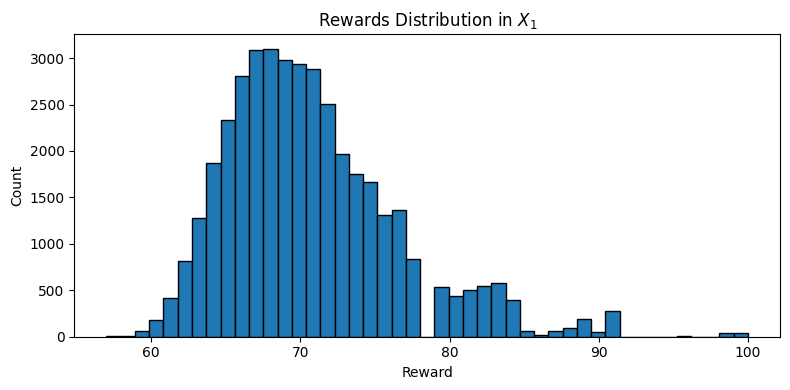

In [ ]:
# Compare with Figure 3 in the paper

plt.figure(figsize=(8, 4))
plt.hist(X_1_rewards, bins=45, edgecolor='black', linewidth=1)
plt.title('Rewards Distribution in $X_1$')
plt.xlabel('Reward')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

__Remark__

As you can see, the new distribution is worse that the one presented in the paper. There can be quite a few reasons for that: different generation paramaters, non-equivalent training process and so on. Moreover, authors claim that for 100k generated samples they get 37k valid sequences, i.e. sequences of length precisely $N(N-1)/2.$ For our generation the corresponding number is much lower.

# Step 4: the main PatternBoost loop. 

Now we will assemble all the previous steps in one training loop. We will save all the intermediate $X_i$ and the models and in the end plot the corresponding histograms of rewards.

In [44]:
all_X_i = {}
all_X_i[0] = X_0
all_X_i[1] = X_1

# We will do three more generations. We will call the last generation by X_i
for i in range(1, 4):
    print(f"Starting generation {i}...")

    # select the top examples
    X_i = all_X_i[i]
    X_i = X_i.sort("reward", reverse=True)
    X_i_top = X_i.select(range(len(X_i) // 4))

    # tokenize and do the train/test split
    X_i_top_text = X_i_top.remove_columns(["reward"])
    X_i_top_tokenized = X_i_top_text.map(
        tokenize_function,
        batched=True,
        remove_columns=["text"]
    )
    split_datasets = X_i_top_tokenized.train_test_split(test_size=0.1)

    # refresh the output and logging directories in the training arguments
    training_args.output_dir = os.path.join(data_path, f"generation_{i}")
    training_args.logging_dir = os.path.join(data_path, f"logs/generation_{i}")

    # reduce evaluation and logging steps even more to avoid excessive output
    training_args.eval_steps = 3000
    training_args.logging_steps = 3000

    # put the new arguemtns into the trainer and refresh the train and eval datasets
    trainer.args = training_args
    trainer.train_dataset = split_datasets["train"]
    trainer.eval_dataset = split_datasets["test"]
    
    # run the training
    trainer.train()
    trainer.save_model(os.path.join(data_path, f"model_{i}"))

    # generation remains unchanged
    generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device=device
    )
    print("Generating new samples...")
    new_samples = []

    pbar = tqdm(total=40_000)
    while len(new_samples) < 40_000:

        outputs = generator(
            [tokenizer.bos_token],
            max_length=50,
            do_sample=True,
            temperature=1.0,
            num_return_sequences=10_000,
            pad_token_id=tokenizer.eos_token_id,
            truncation=True
        )

        for output in outputs[0]:
            text = output['generated_text']
            text = text.replace(tokenizer.bos_token, "").replace(" ", "")
            if len(text) >= N * (N - 1) // 2:
                new_samples.append(text[: N * (N - 1) // 2])
                pbar.update(1)
                if len(new_samples) >= 40_000:
                    break

        torch.cuda.empty_cache()

    new_samples = new_samples[:40_000]

    tasks1 = [(s, N) for s in new_samples]

    # I am not sure if multiprocessing can pick up the auxilary functions from other cells, so I am repeating them here
    def process_search(args):
        return A(*args)

    with Pool() as pool:
        X_i_next_text = list(tqdm(pool.imap_unordered(process_search, tasks1),
                                total=len(tasks1)))

    tasks2 = [(s, N) for s in X_i_next_text]

    def process_reward(args):
        return r(*args)

    with Pool() as pool:
        X_i_next_rewards= list(tqdm(pool.imap_unordered(process_reward, tasks2),
                                    total=len(tasks2)))

    X_i_next = Dataset.from_dict({'text': X_i_next_text, 'reward': X_i_next_rewards})

    X_i_next.save_to_disk(os.path.join(data_path, f"X_{i + 1}"))

    all_X_i[i + 1] = X_i_next

    print(f"Generation {i} is done.")

Starting generation 1...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
3000,3.845600,3.819771
6000,3.838200,3.816998
9000,3.834800,3.816240
12000,3.831900,3.811434
15000,3.830100,3.810759


Generating new samples...


  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/40000 [00:00<?, ? examples/s]

Generation 1 is done.
Starting generation 2...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
3000,3.749400,3.709628
6000,3.744100,3.708854
9000,3.741700,3.704291
12000,3.739900,3.704484
15000,3.738600,3.706264


Generating new samples...


  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/40000 [00:00<?, ? examples/s]

Generation 2 is done.
Starting generation 3...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
3000,3.636900,3.589087
6000,3.633000,3.587261
9000,3.631000,3.584819
12000,3.629100,3.585343
15000,3.627400,3.583124


Generating new samples...


  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/40000 [00:00<?, ? examples/s]

Generation 3 is done.


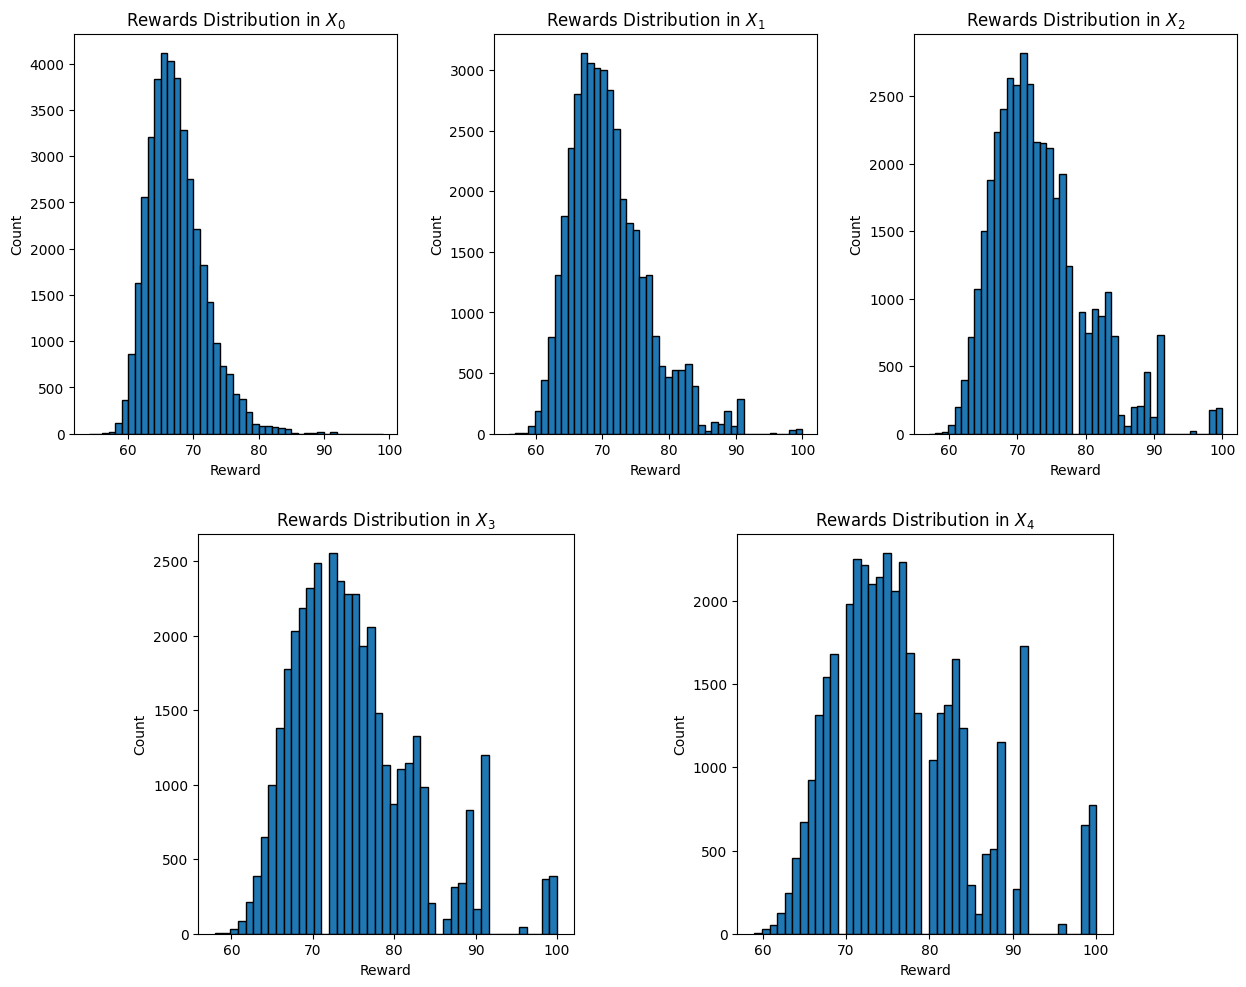

In [ ]:
# Now lets plot our reward distributions for all X_i and compare with Figure 4 in the paper

fig = plt.figure(figsize=(15, 10))

gs_top = gridspec.GridSpec(1, 3, top=0.95, bottom=0.55, wspace=0.3)
ax1 = fig.add_subplot(gs_top[0])
ax2 = fig.add_subplot(gs_top[1])
ax3 = fig.add_subplot(gs_top[2])


gs_bottom = gridspec.GridSpec(1, 7, top=0.45, bottom=0.05,
                            width_ratios=[1, 2, 2, 1, 2, 2, 1], wspace=0.3)
ax4 = fig.add_subplot(gs_bottom[1:3])
ax5 = fig.add_subplot(gs_bottom[4:6])

# Plot histograms for X_0 through X_4
ax1.hist(all_X_i[0]['reward'], bins=45, edgecolor='black', linewidth=1)
ax1.set_title('Rewards Distribution in $X_0$')
ax1.set_xlabel('Reward')
ax1.set_ylabel('Count')

ax2.hist(all_X_i[1]['reward'], bins=45, edgecolor='black', linewidth=1)
ax2.set_title('Rewards Distribution in $X_1$')
ax2.set_xlabel('Reward')
ax2.set_ylabel('Count')

ax3.hist(all_X_i[2]['reward'], bins=45, edgecolor='black', linewidth=1)
ax3.set_title('Rewards Distribution in $X_2$')
ax3.set_xlabel('Reward')
ax3.set_ylabel('Count')

ax4.hist(all_X_i[3]['reward'], bins=45, edgecolor='black', linewidth=1)
ax4.set_title('Rewards Distribution in $X_3$')
ax4.set_xlabel('Reward')
ax4.set_ylabel('Count')

ax5.hist(all_X_i[4]['reward'], bins=45, edgecolor='black', linewidth=1)
ax5.set_title('Rewards Distribution in $X_4$')
ax5.set_xlabel('Reward')
ax5.set_ylabel('Count')

plt.show()


__Conclusion__ 

Although our histograms are not as pretty as those presented by authors, we nevertheless can cleary see some shift in the reward distribution towards its tail. Effectively it means that our model learned to generate triangle-free graphs with $100$ edges, i.e. complete bipartite graphs on $20$ vertices. I am sure that after playing with the training and generation parameters, prettier results can be acheived. Thank you for following along.